To extract water bodies from land surfaces, this script generates Landsat-based water masks resulted from different combinations of parameters, i.e. water index, temporal reducer, and scaled Otsu's threshold, and test the accuracy of all water masks with ROC.

## Load Packages

In [ ]:
# Link to Drive
from google.colab import drive
drive.mount('/content/drive')

# Connect to Earth Engine
import ee
ee.Authenticate()
ee.Initialize()

Mounted at /content/drive
To authorize access needed by Earth Engine, open the following URL in a web browser and follow the instructions. If the web browser does not start automatically, please manually browse the URL below.

    https://accounts.google.com/o/oauth2/auth?client_id=517222506229-vsmmajv00ul0bs7p89v5m89qs8eb9359.apps.googleusercontent.com&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fearthengine+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdevstorage.full_control&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&response_type=code&code_challenge=WQIW5hkdT0sl4EdWltv1E0OBUzogFW4i_dbkLQBvY94&code_challenge_method=S256

The authorization workflow will generate a code, which you should paste in the box below. 
Enter verification code: 4/1AX4XfWhezX61yxWcjORrmDtzp7-8WKNwnpB9NzzOeOWLQC4M58E2I4LBRv0

Successfully saved authorization token.


In [ ]:
!pip install geopandas
!pip install geojson
!pip install geemap
!pip install seaborn

import os
from glob import glob
import numpy as np
import pandas as pd
import geojson
import shapely as shp
from shapely.geometry import Polygon
import geopandas as gpd
import matplotlib.pyplot as plt
import geemap
import seaborn as sns

     |████████████████████████████████| 1.0 MB 29.3 MB/s 
     |████████████████████████████████| 6.3 MB 27.9 MB/s 
     |████████████████████████████████| 16.7 MB 415 kB/s 
     |████████████████████████████████| 1.9 MB 27.2 MB/s 
     |████████████████████████████████| 187 kB 44.3 MB/s 
     |████████████████████████████████| 130 kB 60.1 MB/s 
     |████████████████████████████████| 3.3 MB 57.7 MB/s 
     |████████████████████████████████| 1.7 MB 54.5 MB/s 
     |████████████████████████████████| 98 kB 7.9 MB/s 
     |████████████████████████████████| 8.7 MB 28.1 MB/s 
     |████████████████████████████████| 76 kB 5.5 MB/s 
     |████████████████████████████████| 5.4 MB 42.8 MB/s 
     |████████████████████████████████| 95 kB 3.4 MB/s 
     |████████████████████████████████| 44 kB 2.4 MB/s 
     |████████████████████████████████| 216 kB 58.3 MB/s 
     |████████████████████████████████| 1.2 MB 45.9 MB/s 
     |████████████████████████████████| 99 kB 7.7 MB/s 
     |██████████████████

## Load ROIs (parcel)

In [ ]:
# Load all parcels
os.chdir('/content/drive/MyDrive/THESIS_AQUAPONDS/ROI/Aquaculture_Asia_Coast_2019/Coastline_parcels_polygon')
path_parcels = glob(os.path.join(os.getcwd(), 'parcels.geojson'))[0]
parcels = gpd.read_file(path_parcels).sort_values('TARGET_FID')

parcels.head()

,fid,TARGET_FID,GID_0,NAME_0,Shape_Area,geometry
0,1,215,JPN,Japan,7.774520e+10,"MULTIPOLYGON (((147.70812 43.07955, 146.24364 ..."
1,2,216,JPN,Japan,6.692903e+10,"MULTIPOLYGON (((143.48255 43.51240, 142.55864 ..."
51,52,336,JPN,Japan,6.854787e+10,"MULTIPOLYGON (((143.48255 43.51240, 145.36744 ..."
52,53,455,JPN,Japan,4.888277e+10,"MULTIPOLYGON (((142.54397 46.95565, 142.55864 ..."
53,54,462,CHN,China,8.068226e+10,"MULTIPOLYGON (((132.39052 41.62522, 130.12027 ..."


In [ ]:
# Get Parcel IDs
#parcelIDs = sorted(list(parcels['TARGET_FID']))
#parcelIDs = [667, 669, 671]
#print(parcelIDs)

In [ ]:
#parcels.to_file('parcels.geojson', driver='GeoJSON')
with open('parcels.geojson') as f:
  parcels_geojson = geojson.load(f)

## Function: Get TPR & FPR

### Level-II Functions

In [ ]:
# Function to Mask Clouds
def maskCloud(image):
  """ Mask out clouds and cloud shadows from Landsat Image

  Parameters
  ----------
  image: ee.Image
    Landsat Surface Reflectance Image
  
  Returns
  ----------
  image: ee.Image
    Image with cloud and cloud shadow masked out
  """

  cloudMask = image.select(['pixel_qa']).bitwiseAnd(1<<5).eq(0)
  cloudShadowMask = image.select(['pixel_qa']).bitwiseAnd(1<<3).eq(0)
  final_mask = cloudMask.And(cloudShadowMask)
  return image.updateMask(final_mask)

In [ ]:
# Function to add water Index bands
def addIndex(image):
  """ Add water indices as new bands

  Parameter
  ----------
  image: ee.Image
    Landsat Surface Reflectance Image

  Returns
  ----------
  image: ee.Image
    Image with four new water indices bands
  """
  
  ndwi = image.normalizedDifference(['green', 'nir']).rename(['ndwi'])
  # https://www.tandfonline.com/doi/abs/10.1080/01431169608948714
  
  mndwi = image.normalizedDifference(['green', 'swir1']).rename(['mndwi'])
  # https://www.tandfonline.com/doi/abs/10.1080/01431160600589179
  
  awei = image.expression("blue + 2.5*green - 1.5*(nir+swir1) - 0.25*swir2", {
    'blue': image.select(['blue']),
    'green': image.select(['green']),
    'nir': image.select(['nir']),
    'swir1': image.select(['swir1']),
    'swir2': image.select(['swir2'])
  }).rename(['awei'])
  # https://www.sciencedirect.com/science/article/pii/S0034425713002873
  
  wiFi = image.expression("1.7204 + 171*green +3*red - 70*nir - 45*swir1 - 71*swir2",{
    'green': image.select(['green']),
    'red': image.select(['red']),
    'nir': image.select(['nir']),
    'swir1': image.select(['swir1']),
    'swir2': image.select(['swir2'])
  }).rename(['wiFi'])
  # https://www.sciencedirect.com/science/article/abs/pii/S0034425715302753
  
  return image.addBands([ndwi, mndwi, awei, wiFi])


In [ ]:
# Function of Otsu I.
def otsu(histogram):
  """ Calculate Thresholds based on histogram using Otsu method

  Paramter
  ---------
  histogram: Dictionary
    The output dictionary of ee.Image.reduceRegion() where the reducer is ee.Reducer.histogram()

  Returns:
  ----------
  ...
  """

  counts = ee.Array(ee.Dictionary(histogram).get('histogram'))
  means = ee.Array(ee.Dictionary(histogram).get('bucketMeans'))
  size = means.length().get([0])
  total = counts.reduce(ee.Reducer.sum(), [0]).get([0])
  sum = means.multiply(counts).reduce(ee.Reducer.sum(), [0]).get([0])
  mean = sum.divide(total)

  indices = ee.List.sequence(1, size)

  def iFunc(i):
    aCounts = counts.slice(0, 0, i) 
    aCount = aCounts.reduce(ee.Reducer.sum(), [0]).get([0])
    aMeans = means.slice(0, 0, i)
    aMean = aMeans.multiply(aCounts).reduce(ee.Reducer.sum(),[0]).get([0]).divide(aCount)
    bCount = total.subtract(aCount)
    bMean = sum.subtract(aCount.multiply(aMean)).divide(bCount)
    return aCount.multiply(aMean.subtract(mean).pow(2)) \
          .add(bCount.multiply(bMean.subtract(mean).pow(2)))

  # Compute between sum of squares, where each mean partitions the data
  bss = indices.map(iFunc)

  return means.sort(bss).get([-1])

In [ ]:
# Function of Otsu II: Get initial Otsu Threshold
def get_threshold(image, waterIndices, roi):
  """ A wrapped funtion to apply the Otsu method function from above

  Parameter
  ----------
  image: ee.Image
    The image to calculate Otsu threshold from
  waterIndices: List
    A list of water index bands
  roi: ee.Geometry
    The geometry of study region

  Returns
  ---------
  thrhs: List
    A list of Otsu Threshold values where each elements is the threshold for corresponding input water index band
  """
  
  index = waterIndices

  histogram = image.select([index]).reduceRegion(
      reducer = ee.Reducer.histogram().combine('mean', None, True).combine('variance', None, True),
      geometry = roi.getInfo(),
      scale = 30,
      maxPixels = 10e12,
      bestEffort = True)

  #thrhs = [otsu(h.get(i+'_histogram')) for h,i in zip(histograms,[indices])]
  thrhs = otsu(histogram.get(index+'_histogram'))

  return thrhs

In [ ]:
# Get Water Masks
def get_mask(image, waterIndices, threshold):
  """ Calculate Binary Mask

  Parameter
  ----------
  image: ee.Image
    Image to calculate water masks from
  waterIndices: String
    water index band name
  threshold: Number
    Threshold Value

  Returns
  ---------
  watermasks: ee.Image
    Water mask 
  """

  indices = waterIndices
  #watermasks = [image.select([i]).gt(t).rename(['watermask_'+i]).unmask(0) for i,t in zip([indices],[threshold])]
  watermasks = image.select([indices]).gt(threshold).rename(['watermask_'+indices]).unmask(0)
  # Water = 1, Land = 0
  return watermasks

### Level-I Functions

In [ ]:
# Rasterize the Pond Polygons at test site
def rasterize_testSite(parcelID):
  """ Rasterize the Pond Polygons"""

  # Load Test Site
  os.chdir('/content/drive/MyDrive/THESIS_AQUAPONDS/ROI/Aquaculture_Asia_Coast_2019/ROC_testSites/')
  testSites = glob(os.path.join(os.getcwd(), "*"+str(parcelID)+"*"))
  with open(testSites[0].split('/')[-1]) as f:
    testSite_geojson = geojson.load(f)

  # Create Feature Collection of all ponds at test site
  geoms = [ee.Geometry(i['geometry']) for i in testSite_geojson['features']]
  features = [ee.Feature(i) for i in geoms]
  featCol = ee.FeatureCollection(features).map(lambda feature: feature.set('ref', 1))

  # Rasterize test site: pond = 1, land = 0
  bbox = featCol.union().geometry().bounds()
  img_ref = featCol.reduceToImage(['ref'], ee.Reducer.firstNonNull()).unmask(0).clip(bbox)
  img_ref = img_ref.rename(['reference'])

  return img_ref, bbox

In [ ]:
# Get ROI for input to EE.
def get_roi(parcelID):

  ROI = [i['geometry'] for i in parcels_geojson['features'] if i['properties']['TARGET_FID']==parcelID]
  roi = ee.Geometry(ROI[0])
  
  return roi

In [ ]:
# Get Image of a defined water Index
def get_index_img(roi, reducer):

  # Load Landsat Archives
  ls8 = ee.ImageCollection("LANDSAT/LC08/C01/T1_SR") \
          .filterDate('2019', '2020') \
          .select(['B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'pixel_qa'], ['blue', 'green', 'red', 'nir', 'swir1', 'swir2', 'pixel_qa']) \
          .filterBounds(roi) \
          .sort("system:time_start", True)
  ls7 = ee.ImageCollection("LANDSAT/LE07/C01/T1_SR") \
        .filterDate('2019', '2020') \
        .select(['B1', 'B2', 'B3', 'B4', 'B5', 'B7', 'pixel_qa'], ['blue', 'green', 'red', 'nir', 'swir1', 'swir2', 'pixel_qa']) \
        .filterBounds(roi) \
        .sort("system:time_start", True)

  # Merge Collections + Mask Cloud + Add water index bands
  ls_all = ls8.merge(ls7)
  ls_all = ls_all.sort('system:time_start', True).map(maskCloud).map(addIndex)

  # Reduce by Median
  if reducer=='median':
    index_img = ls_all.median().set({'year': 2019, 'system:time_start': ee.Date.fromYMD(2019, 12, 31)})
  elif reducer=='95th':
    index_img = ls_all.reduce(ee.Reducer.percentile([95])).set({'year': 2019, 'system:time_start': ee.Date.fromYMD(2019, 12, 31)})
  return index_img


In [ ]:
# Get initial Otsu Threshold based on the input water index image.
def Get_threshold(indexImg, waterIndices, roi):
  # Apply Otsu
  roi = roi
  waterIndices = waterIndices
  threshold_origin = get_threshold(image = indexImg, waterIndices = waterIndices, roi = roi)
  return threshold_origin

In [ ]:
# Get Binary Mask based on the input water index image and Threshold.
def Get_mask(indexImg, threshold, bbox, waterIndices, reducer):
  waterIndices = waterIndices
  reducer = reducer
  img_pred = get_mask(image = indexImg, waterIndices = waterIndices, threshold = threshold).clip(bbox)
  img_pred = img_pred.rename(['pred_'+waterIndices+'_'+reducer])
  return img_pred

In [ ]:
# Sample Features from the reference and predicted Images, Calculate TPR and FPR
def sample_pred_ref_img(img_pred, img_ref, bbox):
  img_to_sample = img_pred.addBands(img_ref)
  my_sample = img_to_sample.sample(bbox, 30)

  property_keys = my_sample.toDictionary().values().getInfo()[0]
  #print(property_keys)
  property_values = [np.array(my_sample.aggregate_array(i).getInfo()) for i in property_keys]
  property_dic = dict(zip(property_keys, property_values))

  pred = property_dic.get(property_keys[0])
  reference = property_dic.get(property_keys[1])

  fp = np.sum((pred == 1) & (reference == 0))
  tp = np.sum((pred == 1) & (reference == 1))

  fn = np.sum((pred == 0) & (reference == 1))
  tn = np.sum((pred == 0) & (reference == 0))

  fpr = fp / (fp + tn)
  tpr = tp / (tp + fn)

  return fpr, tpr

### Level-0 Function

In [ ]:
#def getEM_single(parcelID, waterIndices, reducer):

#  img_ref, bbox = rasterize_testSite(parcelID = parcelID)

#  roi = get_roi(parcelID = parcelID)

#  index_img = get_index_img(roi = roi, reducer = reducer)

#  waterIndices = waterIndices

#  threshold = Get_threshold(indexImg = index_img, waterIndices = waterIndices, roi = roi)

#  img_pred = Get_mask(indexImg = index_img, threshold = threshold, bbox = bbox, waterIndices = waterIndices, reducer = reducer)

#  fpr, tpr = sample_pred_ref_img(img_pred = img_pred, img_ref = img_ref, bbox = bbox)

#  return fpr, tpr

In [ ]:
def getEM(parcelID, waterIndices, reducer, factors):

  img_ref, bbox = rasterize_testSite(parcelID = parcelID)

  roi = get_roi(parcelID = parcelID)

  index_img = get_index_img(roi = roi, reducer = reducer)

  if reducer == '95th':
    waterIndices = waterIndices+'_p95'
  else:
    waterIndices = waterIndices

  threshold = Get_threshold(indexImg = index_img, waterIndices = waterIndices, roi = roi)
  factors = factors
  thresholds = [i*threshold.getInfo() for i in factors]
  
  img_preds = [Get_mask(indexImg = index_img, threshold = threshold, bbox = bbox, waterIndices = waterIndices, reducer = reducer) for threshold in thresholds]

  em = [sample_pred_ref_img(img_pred = img_pred, img_ref = img_ref, bbox = bbox) for img_pred in img_preds]
  return em, thresholds
  #ls_fpr=[]
  #ls_tpr=[]
  #for img_pred in img_preds:
  #  fpr, tpr = sample_pred_ref_img(img_pred = img_pred, img_ref = img_ref, bbox = bbox)
  #  ls_fpr.append(fpr)
  #  ls_tpr.append(tpr)
  #return ls_fpr, ls_tpr
  

* Copy this function four times, for `wiFi+median`, `wiFi+95th`, `mndwi+median`, `mndwi+95th` combis.

* Merge Output DFs.

In [ ]:
#factors = np.arange(0.90, 1.0, 0.02)
#em = getEM(parcelID=667, waterIndices='awei', reducer='median', factors=factors)
#print(em)

In [ ]:
#df_wiFi_median = pd.DataFrame(em[0], columns=['fpr', 'tpr'])
#df_wiFi_median['factors'] = factors
#df_wiFi_median['threshold'] = em[1]
#df_wiFi_median

## Export DFs of TPR & FPR

In [ ]:
import itertools as it

In [ ]:
outPath = '/content/drive/My Drive/myExportImage/ROC_DFs/'

#parcelIDs = [667, 669, 671]
indices = ['ndwi', 'mndwi', 'awei', 'wiFi']
reducers = ['median', '95th']
parcelIDs = [540, 658, 667]
#indices = ['wiFi']
#reducers = ['95th']
args = list(it.product(parcelIDs, indices, reducers))

def genFun(n): # n = len(args)
  
  factors = np.arange(0.70, 1.31, 0.01)

  i = 0
  while i < n:
    parcelID = args[i][0]
    waterIndex = args[i][1]
    reducer = args[i][2]

    em = getEM(parcelID=parcelID, waterIndices=waterIndex, reducer=reducer, factors=factors)

    df = pd.DataFrame(em[0], columns=['fpr', 'tpr'])
    df['factors'] = factors
    df['thresholds'] = em[1]
    df['parcelID'] = parcelID
    df['waterIndex'] = waterIndex
    df['reducer'] = reducer

    yield df.to_csv(os.path.join(outPath, 'p_'+str(parcelID)+'_'+waterIndex+'_'+reducer+'_v3.csv'), sep='\t', encoding='utf-8', index=False)
    i += 1

gen = genFun(len(args))

In [ ]:
# Exhaust Generator
# Reference: https://stackoverflow.com/questions/47456631/simpler-way-to-run-a-generator-function-without-caring-about-items
from collections import deque

def exhaust(generator):
    deque(generator, maxlen=0)

exhaust(gen)

## ROC

### Concatenate

In [ ]:
outPath = '/content/drive/My Drive/myExportImage/ROC_DFs/'
files = glob(os.path.join(outPath, "*v3*"))
files

['/content/drive/My Drive/myExportImage/ROC_DFs/p_540_ndwi_median_v3.csv',
 '/content/drive/My Drive/myExportImage/ROC_DFs/p_540_ndwi_95th_v3.csv',
 '/content/drive/My Drive/myExportImage/ROC_DFs/p_540_mndwi_median_v3.csv',
 '/content/drive/My Drive/myExportImage/ROC_DFs/p_540_mndwi_95th_v3.csv',
 '/content/drive/My Drive/myExportImage/ROC_DFs/p_540_awei_median_v3.csv',
 '/content/drive/My Drive/myExportImage/ROC_DFs/p_540_awei_95th_v3.csv',
 '/content/drive/My Drive/myExportImage/ROC_DFs/p_540_wiFi_median_v3.csv',
 '/content/drive/My Drive/myExportImage/ROC_DFs/p_540_wiFi_95th_v3.csv',
 '/content/drive/My Drive/myExportImage/ROC_DFs/p_658_ndwi_median_v3.csv',
 '/content/drive/My Drive/myExportImage/ROC_DFs/p_658_ndwi_95th_v3.csv',
 '/content/drive/My Drive/myExportImage/ROC_DFs/p_658_mndwi_median_v3.csv',
 '/content/drive/My Drive/myExportImage/ROC_DFs/p_658_mndwi_95th_v3.csv',
 '/content/drive/My Drive/myExportImage/ROC_DFs/p_658_awei_median_v3.csv',
 '/content/drive/My Drive/myExpor

In [ ]:
dfs = [pd.read_csv(i, sep='\t') for i in files]
len(dfs)

24

In [ ]:
df = pd.concat(dfs, ignore_index=True)
df.index

RangeIndex(start=0, stop=1488, step=1)

### Euclidean Distance

In [ ]:
df.head()

,fpr,tpr,factors,thresholds,parcelID,waterIndex,reducer,eucDis
0,0.005464,0.420712,0.80,-0.153152,667,ndwi,median,0.579314
1,0.005464,0.423948,0.81,-0.155067,667,ndwi,median,0.576078
2,0.005464,0.430421,0.82,-0.156981,667,ndwi,median,0.569606
3,0.005464,0.436893,0.83,-0.158895,667,ndwi,median,0.563133
4,0.005464,0.436893,0.84,-0.160810,667,ndwi,median,0.563133


In [ ]:
import math
df['eucDis'] = (df['fpr']-0)**2 + (df['tpr']-1)**2
df['eucDis'] = df['eucDis'].astype(float).apply(math.sqrt)

In [ ]:
df.to_csv(os.path.join(outPath, 'allParam_v3.csv'), sep='\t', encoding='utf-8', index=False)

### ROC, p-667

In [ ]:
outPath = '/content/drive/My Drive/myExportImage/ROC_DFs/'
file = glob(os.path.join(outPath, 'allParam_v3.csv'))
df = pd.read_csv(file[0], sep='\t')

In [ ]:
ids = [540, 658, 667]

In [ ]:
df_sub = df[df.parcelID==ids[0]]
df_sub.reset_index(drop=True, inplace=True)
df_sub.head()

,fpr,tpr,factors,thresholds,parcelID,waterIndex,reducer,eucDis
0,0.0,0.089912,0.70,-0.060275,540,ndwi,median,0.910088
1,0.0,0.092105,0.71,-0.061136,540,ndwi,median,0.907895
2,0.0,0.096491,0.72,-0.061997,540,ndwi,median,0.903509
3,0.0,0.098684,0.73,-0.062858,540,ndwi,median,0.901316
4,0.0,0.098684,0.74,-0.063719,540,ndwi,median,0.901316


In [ ]:
# Params at Optimal Threshold
df_sub[df_sub['eucDis']==min(df_sub['eucDis'])]

,fpr,tpr,factors,thresholds,parcelID,waterIndex,reducer,eucDis
417,0.127049,0.837719,1.15,-132658.852640,540,wiFi,median,0.206098
418,0.127049,0.837719,1.16,-133812.407881,540,wiFi,median,0.206098


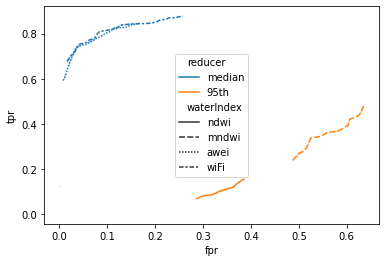

In [ ]:
plot = sns.lineplot(data=df_sub, x='fpr', y='tpr', hue='reducer', style='waterIndex')
#plt.scatter(x=df_sub.fpr[index_optThr], y=df_sub.tpr[index_optThr], color='r')
#plt.gca().text(df.fpr[index_optThr], df.tpr[index_optThr], 'threshold='+str(df.threshold[index_optThr]))

### ROC, p-669

In [ ]:
df_sub = df[df.parcelID==ids[1]]
df_sub.reset_index(drop=True, inplace=True)
df_sub.head()

,fpr,tpr,factors,thresholds,parcelID,waterIndex,reducer,eucDis
0,0.012394,0.338198,0.70,-0.128520,658,ndwi,median,0.661918
1,0.012394,0.339150,0.71,-0.130356,658,ndwi,median,0.660966
2,0.012394,0.341053,0.72,-0.132192,658,ndwi,median,0.659063
3,0.012394,0.344543,0.73,-0.134028,658,ndwi,median,0.655574
4,0.012394,0.347716,0.74,-0.135864,658,ndwi,median,0.652402


In [ ]:
# Params at Optimal Threshold
df_sub[df_sub['eucDis']==min(df_sub['eucDis'])]

,fpr,tpr,factors,thresholds,parcelID,waterIndex,reducer,eucDis
428,0.08711,0.892766,1.26,-139554.987915,658,wiFi,median,0.138157


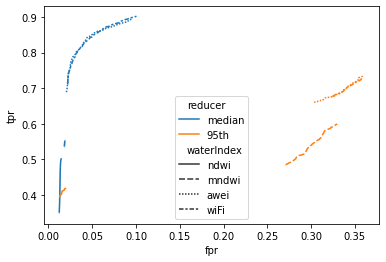

In [ ]:
plot = sns.lineplot(data=df_sub, x='fpr', y='tpr', hue='reducer', style='waterIndex')
#plt.scatter(x=df_sub.fpr[index_optThr], y=df_sub.tpr[index_optThr], color='r')
#plt.gca().text(df.fpr[index_optThr], df.tpr[index_optThr], 'threshold='+str(df.threshold[index_optThr]))

### ROC, p-671

In [ ]:
df_sub = df[df.parcelID==ids[2]]
df_sub.reset_index(drop=True, inplace=True)
df_sub.head()

,fpr,tpr,factors,thresholds,parcelID,waterIndex,reducer,eucDis
0,0.002396,0.336612,0.70,-0.134008,667,ndwi,median,0.663392
1,0.002396,0.340462,0.71,-0.135923,667,ndwi,median,0.659542
2,0.002396,0.344739,0.72,-0.137837,667,ndwi,median,0.655265
3,0.002875,0.350299,0.73,-0.139751,667,ndwi,median,0.649707
4,0.002875,0.354149,0.74,-0.141666,667,ndwi,median,0.645858


In [ ]:
# Params at Optimal Threshold
df_sub[df_sub['eucDis']==min(df_sub['eucDis'])]

,fpr,tpr,factors,thresholds,parcelID,waterIndex,reducer,eucDis
288,0.067561,0.94568,1.1,-3244.165859,667,awei,median,0.08669


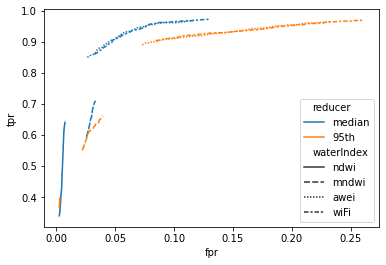

In [ ]:
plot = sns.lineplot(data=df_sub, x='fpr', y='tpr', hue='reducer', style='waterIndex')
#plt.scatter(x=df_sub.fpr[index_optThr], y=df_sub.tpr[index_optThr], color='r')
#plt.gca().text(df.fpr[index_optThr], df.tpr[index_optThr], 'threshold='+str(df.threshold[index_optThr]))

### Explore

In [ ]:
df_good_param = df[(df['reducer']=='median') & (df['waterIndex'].isin(['awei','wiFi']))]

In [ ]:
# p-540
dfSub = df_good_param[df_good_param['parcelID']==540]
percentile2p5 = np.percentile(np.array(dfSub['eucDis']), 15)
dfSub_540 = dfSub[dfSub['eucDis'] < percentile2p5]

In [ ]:
# p-658
dfSub = df_good_param[df_good_param['parcelID']==658]
percentile2p5 = np.percentile(np.array(dfSub['eucDis']), 15)
dfSub_658 = dfSub[dfSub['eucDis'] < percentile2p5]

In [ ]:
# p-667
dfSub = df_good_param[df_good_param['parcelID']==667]
percentile2p5 = np.percentile(np.array(dfSub['eucDis']), 15)
dfSub_667 = dfSub[dfSub['eucDis'] < percentile2p5]

In [ ]:
dfSub = pd.concat([dfSub_540, dfSub_658, dfSub_667], ignore_index=True)
#dfSub.to_csv(os.path.join(outPath, '15th_percentile_v3.csv'), sep='\t', encoding='utf-8', index=False)

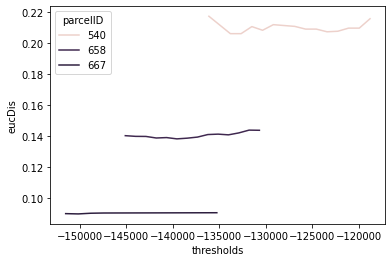

In [ ]:
dfSub_wiFi = dfSub[dfSub['waterIndex']=='wiFi']
plot1 = sns.lineplot(data=dfSub_wiFi, x='thresholds', y='eucDis', hue='parcelID')

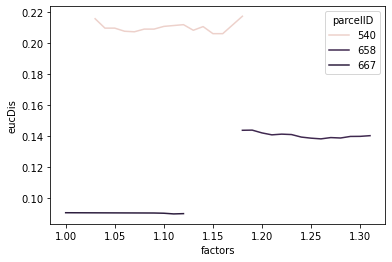

In [ ]:
plot2 = sns.lineplot(data=dfSub_wiFi, x='factors', y='eucDis', hue='parcelID')

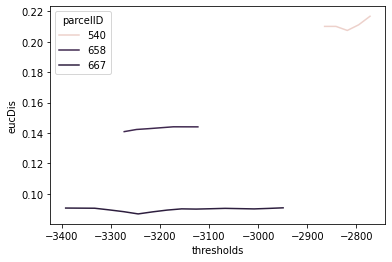

In [ ]:
dfSub_awei = dfSub[dfSub['waterIndex']=='awei']
plot3 = sns.lineplot(data=dfSub_awei, x='thresholds', y='eucDis', hue='parcelID')

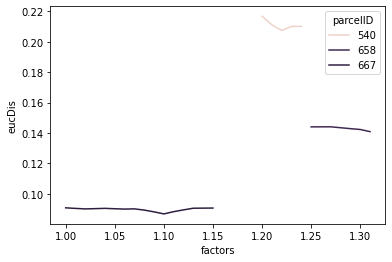

In [ ]:
plot4 = sns.lineplot(data=dfSub_awei, x='factors', y='eucDis', hue='parcelID')